In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define Prometheus API URL and query
PROMETHEUS_API_URL = "http://10.105.116.175:9090/api/v1/query_range"
PROMETHEUS_QUERY_throughput = ["rate(istio_requests_total{namespace='social-network'}[1m])",
                               "rate(istio_requests_total{namespace='social-network2'}[1m])",
                               "rate(istio_requests_total{namespace='social-network3'}[1m])"]
PROMETHEUS_QUERY_latency_avg = [ "rate(istio_request_duration_milliseconds_sum{namespace='social-network'}[1m])/ rate(istio_requests_total{namespace='social-network'}[1m])",
                                 "rate(istio_request_duration_milliseconds_sum{namespace='social-network2'}[1m])/ rate(istio_requests_total{namespace='social-network2'}[1m])",
                                  "rate(istio_request_duration_milliseconds_sum{namespace='social-network3'}[1m])/ rate(istio_requests_total{namespace='social-network3'}[1m])"]

# PROMETHEUS_QUERY_latency_p95 = "histogram_quantile(0.95, sum(rate(istio_request_duration_milliseconds_bucket{namespace='social-network'}[1m])) by (le))"
# Function to query Prometheus API
def query_prometheus(prometheus_url, query, start, end, step):
    params = {
        'query': query,
        'start': start.timestamp(),
        'end': end.timestamp(),
        'step': step
    }
    response = requests.get(prometheus_url, params=params)
    response.raise_for_status()
    return response.json()

# Function to parse Prometheus response
def parse_prometheus_data(data, check_start_time=None, check_end_time=None):
    results = data['data']['result']
    data_list = []
    for result in results:
        metric = result['metric']
        if 'values' in result:
            for value in result['values']:
                timestamp = datetime.utcfromtimestamp(value[0])
                metric_value = float(value[1])

                if (check_start_time is None or timestamp >= check_start_time) and \
                   (check_end_time is None or timestamp <= check_end_time):
                    data_list.append({
                        "metric": metric,
                        "timestamp": timestamp,
                        "value": metric_value
                    })
        else:
            print(f"No 'values' key found in result: {result}")
    return pd.DataFrame(data_list)



In [3]:
'''(1) query data for namesapce of social-network ''' # default k8s scheduling method

# Define the time range for filtering
from tabnanny import check

check_start_time = datetime(2024, 7, 11, 4, 17, 0) # UTC time
check_end_time = datetime(2024, 7, 11, 4, 35, 0)
step = "10s"  # Resolution

# Fetch data from Prometheus
data_throughput_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_throughput[0], check_start_time, check_end_time, step)
data_latency_avg_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_latency_avg[0], check_start_time, check_end_time, step)
# Debugging: Print the raw data to understand its structure
# print(data)

# Parse the data into a DataFrame with time filtering
df_throguput1 = parse_prometheus_data(data_throughput_1, check_start_time, check_end_time)
df_latency_avg1 = parse_prometheus_data(data_latency_avg_1, check_start_time, check_end_time)

# Save the DataFrame to a CSV file (if saved, comment this line)
df_throguput1.to_csv('data/prometheus_data_througuput1.csv', index=False)
df_latency_avg1.to_csv('data/prometheus_data_latency_avg1.csv', index=False) # save the data to csv file

print("Data has been saved to CSV file")

Data has been saved to CSV file


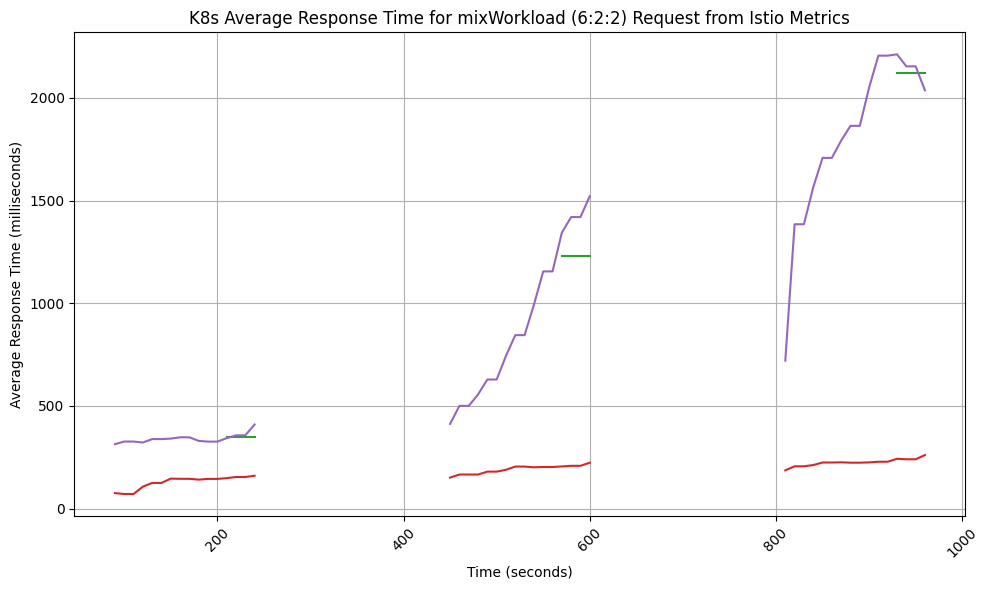

In [6]:
'''(1) plot Response Time for namesapce of social-network ''' # default k8s scheduling method
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/prometheus_data_latency_avg1.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Response Time (milliseconds)')
    plt.title('K8s Average Response Time for mixWorkload (6:2:2) Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot

# print("Plot has been saved to prometheus_data_plot.png")

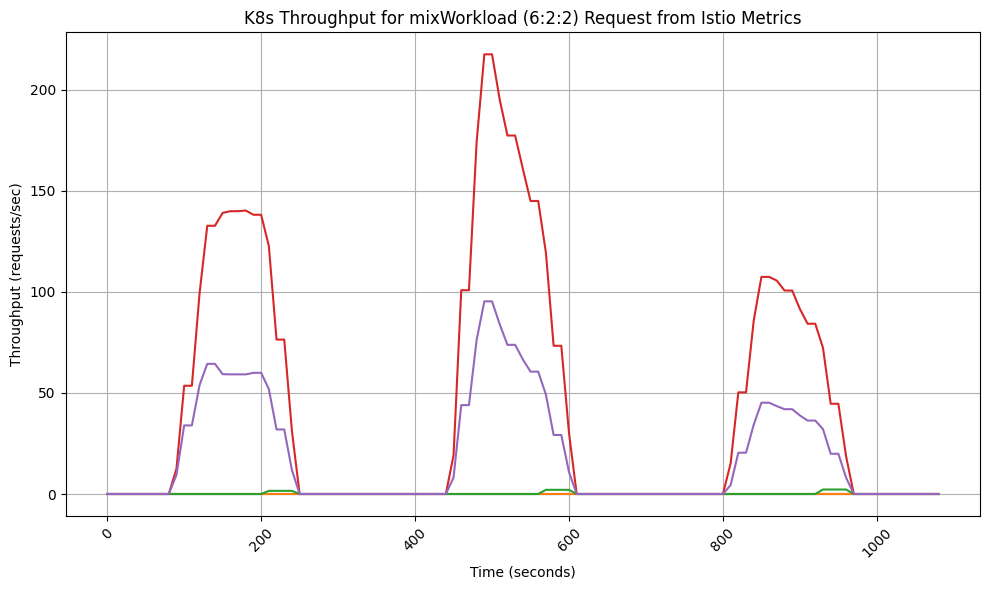

summary of http_status_code counters: 
 Counter({'200': 48, '500': 48, '0': 12})


In [36]:

'''(1) plot Throughput for namesapce of social-network ''' # default k8s scheduling method
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Load the CSV file
file_path = 'data/prometheus_data_througuput1.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (requests/sec)')
    plt.title('K8s Throughput for mixWorkload (6:2:2) Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot

'''calculae different response codes'''
df = pd.read_csv(file_path)
# Convert the 'metric' column dictionaries to actual dictionaries
df['metric'] = df['metric'].apply(ast.literal_eval)
# # Filter the dataframe to include only rows where 'value' is greater than 0
df_filtered = df[df['value'] > 0]

# Extract response codes and count their occurrences
def count_response_codes(dataframe):
    response_codes = dataframe['metric'].apply(lambda x: x.get('response_code', None))
    return Counter(response_codes)
response_code_counts = count_response_codes(df_filtered)
print(f"summary of http_status_code counters: \n {response_code_counts}")

In [8]:
'''(2) query data for namesapce of social-network2 ''' # NetMARKS scheduling method

# Define the time range for filtering
from tabnanny import check


move_back_minutes = 60*19 +47  # Adjust based on actual query
# check_start_time = datetime.now() - timedelta(minutes=move_back_minutes + 60)  # 20 minutes ago
check_start_time = datetime(2024, 7, 11, 4, 20, 0) # UTC time
# check_end_time = datetime.now() - timedelta(minutes=move_back_minutes)  # Now
check_end_time = datetime(2024, 7, 11, 4, 36, 0)
step = "10s"  # Resolution

# Fetch data from Prometheus
data_throughput_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_throughput[1], check_start_time, check_end_time, step)
data_latency_avg_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_latency_avg[1], check_start_time, check_end_time, step)
# Debugging: Print the raw data to understand its structure
# print(data)

# Parse the data into a DataFrame with time filtering
df_throguput1 = parse_prometheus_data(data_throughput_1, check_start_time, check_end_time)
df_latency_avg1 = parse_prometheus_data(data_latency_avg_1, check_start_time, check_end_time)

# Save the DataFrame to a CSV file (if saved, comment this line)
df_throguput1.to_csv('data/prometheus_data_througuput2.csv', index=False)
df_latency_avg1.to_csv('data/prometheus_data_latency_avg2.csv', index=False) # save the data to csv file

print("Data has been saved to CSV file")

Data has been saved to CSV file


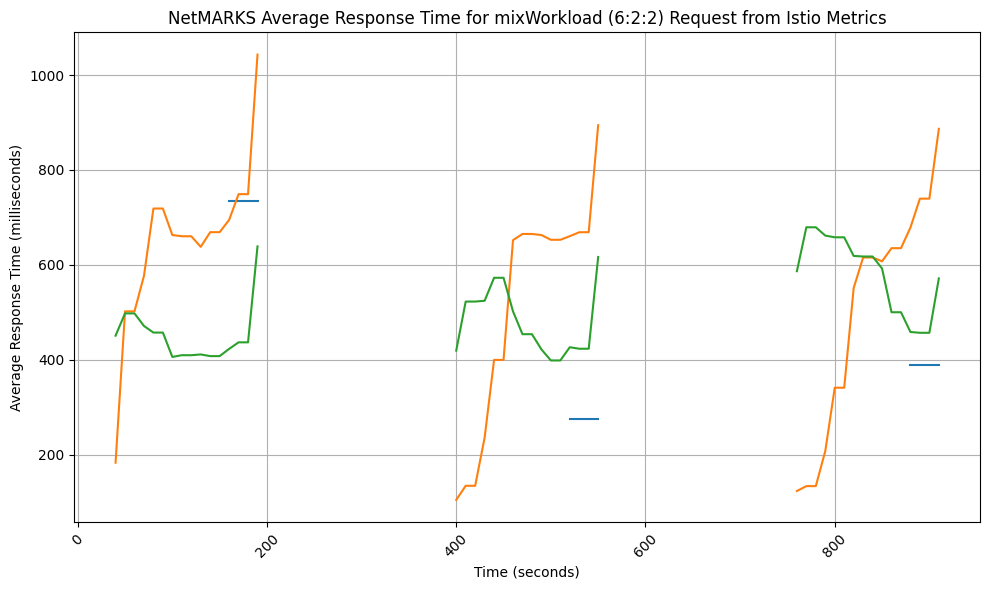

In [9]:
'''(2) plot Response Time for namesapce of social-network2 ''' #NetMARKS scheduling method
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/prometheus_data_latency_avg2.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Response Time (milliseconds)')
    plt.title('NetMARKS Average Response Time for mixWorkload (6:2:2) Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot

# print("Plot has been saved to prometheus_data_plot.png")

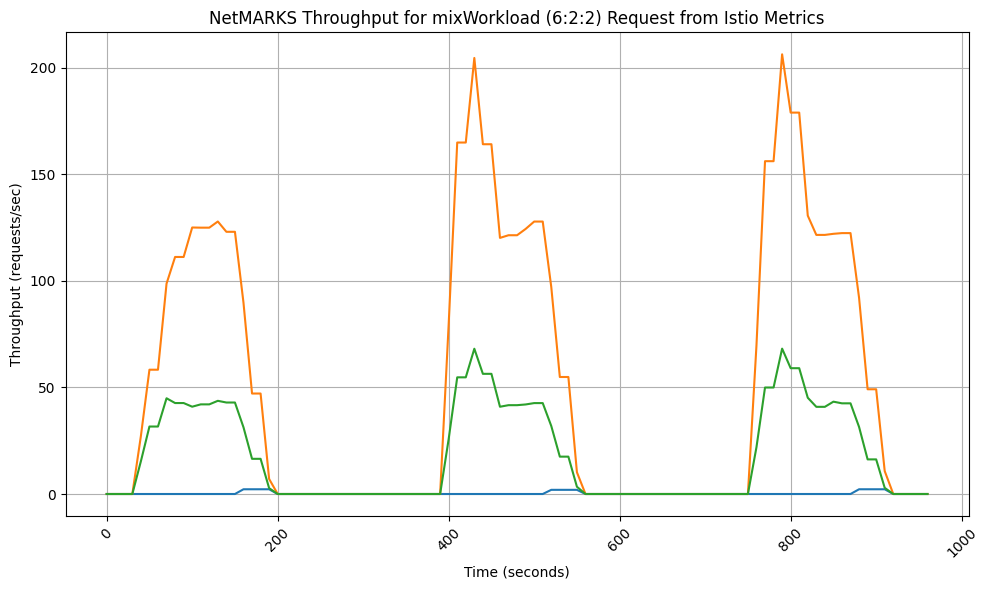

summary of http_status_code counters: 
 Counter({'200': 48, '500': 48, '0': 12})


In [35]:
'''(2) plot Throughput for namesapce of social-network ''' # NetMARKS scheduling method
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Load the CSV file
file_path = 'data/prometheus_data_througuput2.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (requests/sec)')
    plt.title('NetMARKS Throughput for mixWorkload (6:2:2) Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot


'''calculae different response codes'''
df = pd.read_csv(file_path)
# Convert the 'metric' column dictionaries to actual dictionaries
df['metric'] = df['metric'].apply(ast.literal_eval)
# # Filter the dataframe to include only rows where 'value' is greater than 0
df_filtered = df[df['value'] > 0]

# Extract response codes and count their occurrences
def count_response_codes(dataframe):
    response_codes = dataframe['metric'].apply(lambda x: x.get('response_code', None))
    return Counter(response_codes)
response_code_counts = count_response_codes(df_filtered)
print(f"summary of http_status_code counters: \n {response_code_counts}")

In [14]:
'''(3) query data for namesapce of social-network3 ''' # TraDE scheduling method

# Define the time range for filtering
from tabnanny import check
check_start_time = datetime(2024, 7, 11, 4, 20, 0) # UTC time
check_end_time = datetime(2024, 7, 11, 4, 39, 0)
step = "10s"  # Resolution

# Fetch data from Prometheus
data_throughput_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_throughput[2], check_start_time, check_end_time, step)
data_latency_avg_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_latency_avg[2], check_start_time, check_end_time, step)


# Parse the data into a DataFrame with time filtering
df_throguput1 = parse_prometheus_data(data_throughput_1, check_start_time, check_end_time)
df_latency_avg1 = parse_prometheus_data(data_latency_avg_1, check_start_time, check_end_time)

# Save the DataFrame to a CSV file (if saved, comment this line)
df_throguput1.to_csv('data/prometheus_data_througuput3.csv', index=False)
df_latency_avg1.to_csv('data/prometheus_data_latency_avg3.csv', index=False) # save the data to csv file

print("Data has been saved to CSV file")

Data has been saved to CSV file


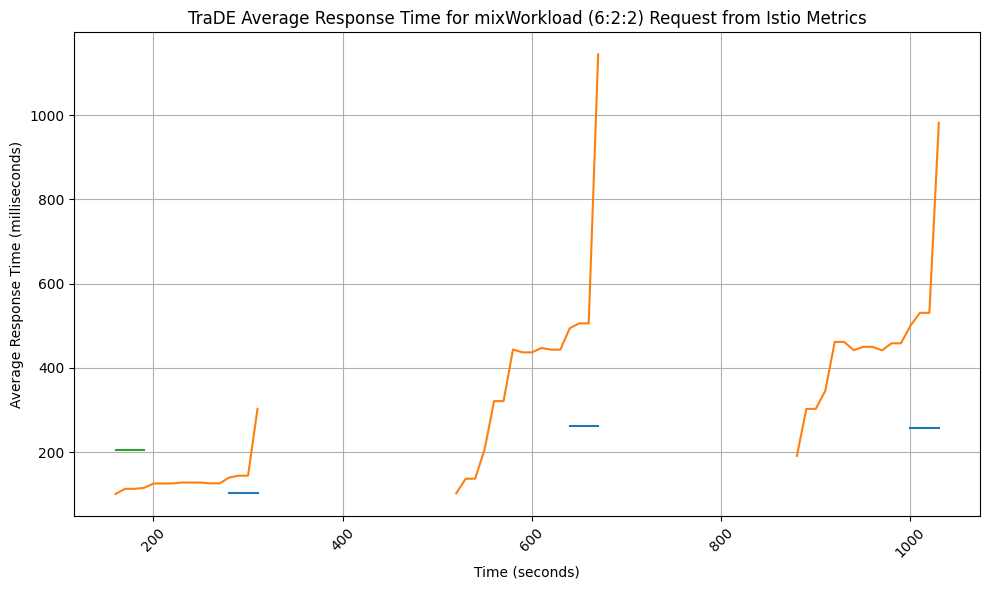

In [15]:
'''(3) plot Response Time for namesapce of social-network2 ''' # TraDE scheduling method
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/prometheus_data_latency_avg3.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Response Time (milliseconds)')
    plt.title('TraDE Average Response Time for mixWorkload (6:2:2) Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot

# print("Plot has been saved to prometheus_data_plot.png")

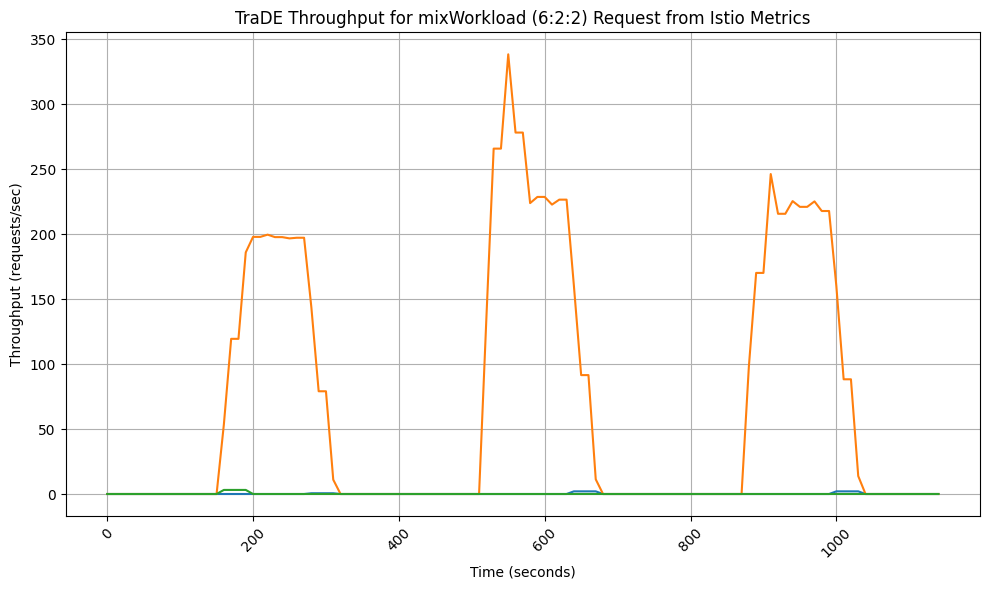

summary of http_status_code counters: 
 Counter({'200': 48, '0': 12, '500': 4})


In [34]:
'''(3) plot Throughput for namesapce of social-network3 ''' # TraDE scheduling method
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Load the CSV file
file_path = 'data/prometheus_data_througuput3.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (requests/sec)')
    plt.title('TraDE Throughput for mixWorkload (6:2:2) Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot


'''calculae different response codes'''
df = pd.read_csv(file_path)
# Convert the 'metric' column dictionaries to actual dictionaries
df['metric'] = df['metric'].apply(ast.literal_eval)
# # Filter the dataframe to include only rows where 'value' is greater than 0
df_filtered = df[df['value'] > 0]

# Extract response codes and count their occurrences
def count_response_codes(dataframe):
    response_codes = dataframe['metric'].apply(lambda x: x.get('response_code', None))
    return Counter(response_codes)
response_code_counts = count_response_codes(df_filtered)
print(f"summary of http_status_code counters: \n {response_code_counts}")

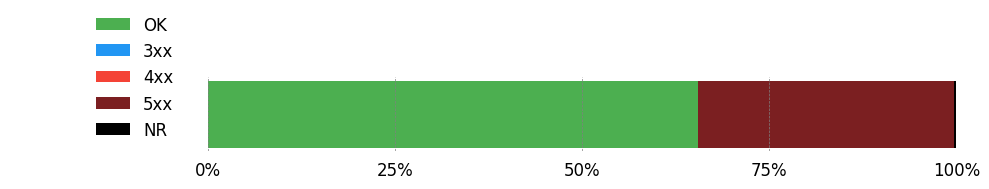

In [35]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Data to plot
categories = ['OK', '3xx', '4xx', '5xx', 'NR']
values = [65.43, 0, 0, 34.28, 0.29]  # Example values
colors = ['#4CAF50', '#2196F3', '#F44336', '#7B1F21', '#000000']  # Corresponding colors

# Create the figure and a GridSpec layout
fig = plt.figure(figsize=(10, 2))
gs = GridSpec(1, 2, width_ratios=[1, 6])

# Create the bar plot in the second column of the GridSpec layout
ax = fig.add_subplot(gs[0, 1])

# Create a stacked horizontal bar chart
left = 0
bars = []
for i, value in enumerate(values):
    bar = ax.barh(0, value, left=left, height=0.3, color=colors[i], edgecolor='none')
    bars.append(bar)
    left += value

# Adding labels to the legend
legend_ax = fig.add_subplot(gs[0, 0])
legend_ax.axis('off')
legend = legend_ax.legend(bars, categories, loc='center', frameon=False, fontsize=12)
legend.set_bbox_to_anchor((0.5, 0.5, 1, 1))

# Customize the axis
ax.set_xlim(0, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize=12)
ax.set_yticks([])  # Hide y-axis ticks
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)

# Add grid lines
ax.grid(axis='x', color='gray', linestyle='--', linewidth=0.5)

# Remove y-axis line and ticks
ax.spines['left'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')

plt.tight_layout()
plt.show()


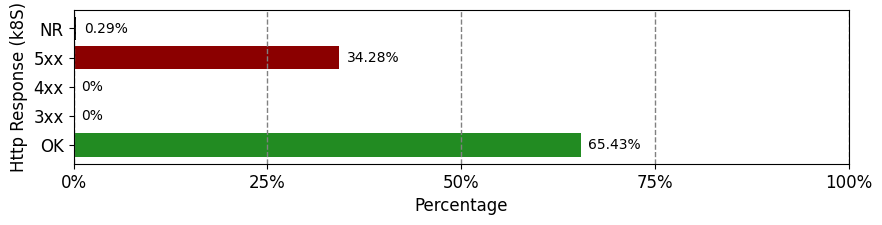

In [18]:
'''k8s method: social -network'''

import matplotlib.pyplot as plt

# Data
categories = ['OK', '3xx', '4xx', '5xx', 'NR']
values = [65.43, 0, 0, 34.28, 0.29]  # Adjust these values based on your specific data

# Colors
colors = ['#228B22', '#1E90FF', '#FF4500', '#8B0000', '#000000']

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 2))  # Aspect ratio 2:1

bars = ax.barh(categories, values, color=colors)

# Customize ticks and labels
ax.set_xlim(0, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize=12)
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories, fontsize=12)

# Set axis labels
ax.set_xlabel("Percentage", fontsize=12)
ax.set_ylabel("Http Response (k8S)", fontsize=12)

# Write the percentage at the right of each bar
for bar, value in zip(bars, values):
    ax.text(value + 1, bar.get_y() + bar.get_height()/2, f'{value}%', va='center', fontsize=10)

# Add grid lines
ax.grid(axis='x', color='gray', linestyle='--', linewidth=1)

# Remove y-axis line and ticks
# ax.spines['left'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_color('none')

# Display the plot
plt.show()


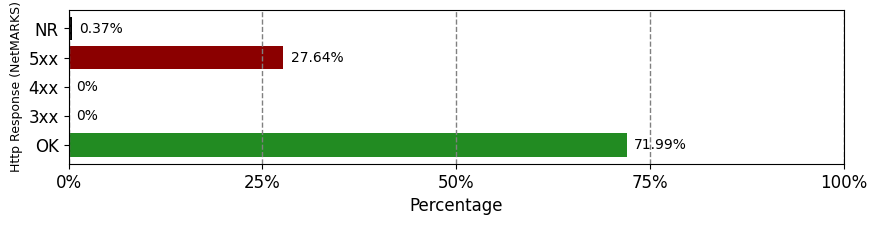

In [21]:
'''NetMarks: social-net2'''

import matplotlib.pyplot as plt

# Data
categories = ['OK', '3xx', '4xx', '5xx', 'NR']
values = [71.99, 0, 0, 27.64, 0.37]  # Adjust these values based on your specific data

# Colors
colors = ['#228B22', '#1E90FF', '#FF4500', '#8B0000', '#000000']

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 2))  # Aspect ratio 2:1

bars = ax.barh(categories, values, color=colors)

# Customize ticks and labels
ax.set_xlim(0, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize=12)
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories, fontsize=12)
# Set axis labels
ax.set_xlabel("Percentage", fontsize=12)
ax.set_ylabel("Http Response (NetMARKS)", fontsize=9)

# Write the percentage at the right of each bar
for bar, value in zip(bars, values):
    ax.text(value + 1, bar.get_y() + bar.get_height()/2, f'{value}%', va='center', fontsize=10)

# Add grid lines
ax.grid(axis='x', color='gray', linestyle='--', linewidth=1)

# Remove y-axis line and ticks
# ax.spines['left'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_color('none')

# Display the plot
plt.show()


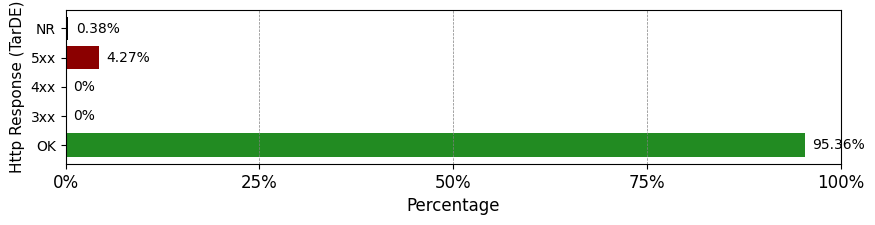

In [23]:
import matplotlib.pyplot as plt

# Data
categories = ['OK', '3xx', '4xx', '5xx', 'NR']
values = [95.36, 0, 0, 4.27, 0.38]  # Adjust these values based on your specific data

# Colors
colors = ['#228B22', '#1E90FF', '#FF4500', '#8B0000', '#000000']

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 2))  # Aspect ratio 2:1

bars = ax.barh(categories, values, color=colors)

# Customize ticks and labels
ax.set_xlim(0, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize=12)
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)

# Set axis labels
ax.set_xlabel("Percentage", fontsize=12)
ax.set_ylabel("Http Response (TarDE)", fontsize=11)

# Write the percentage at the right of each bar
for bar, value in zip(bars, values):
    ax.text(value + 1, bar.get_y() + bar.get_height()/2, f'{value}%', va='center', fontsize=10)

# Add grid lines
ax.grid(axis='x', color='gray', linestyle='--', linewidth=0.5)

# Remove y-axis line and ticks
# ax.spines['left'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_color('none')

# Display the plot
plt.show()
